# Milky Way Disc Age-Metallicity Explorer

This notebook loads trained normalizing flow models and generates visualizations of the age-metallicity relationship across different galactic radial bins.

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import gaussian_kde
from IPython.display import display, HTML
import ipywidgets as widgets
import warnings

# Ignore sklearn warnings about unpickling from different versions
warnings.filterwarnings("ignore", category=UserWarning)

# Need these imports to reconstruct flow model
from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform

## Recreate the Flow5D Model Class

This is an exact copy of the Flow5D class from flow_model.py, to ensure compatibility with the saved model.

In [2]:
class Flow5D(nn.Module):
    """5D normalizing flow for complete Galactic analysis.
    Jointly models [age, [Fe/H], [Mg/Fe], sqrt(Jz), Lz]
    """

    def __init__(
        self,
        n_transforms=16,
        hidden_dims=None,
        num_bins=32,
        tail_bound=5.0,
        use_residual_blocks=True,
        dropout_probability=0.1,
    ):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [256, 256]

        # Base distribution (5D standard normal)
        base_dist = StandardNormal(shape=[5])

        # Build a sequence of transforms
        transforms = []
        for i in range(n_transforms):
            # Add alternating permutation and autoregressive transforms
            transforms.append(ReversePermutation(features=5))

            # Use masked autoregressive transform with rational quadratic splines
            transforms.append(
                MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                    features=5,
                    hidden_features=hidden_dims[0],
                    context_features=None,
                    num_bins=num_bins,
                    tails="linear",
                    tail_bound=tail_bound,
                    num_blocks=4,  # Increased from 2
                    use_residual_blocks=use_residual_blocks,
                    random_mask=False,
                    activation=F.relu,
                    dropout_probability=dropout_probability,
                    use_batch_norm=True,
                )
            )

        # Create the flow model
        self.flow = Flow(
            transform=CompositeTransform(transforms), distribution=base_dist
        )

    def log_prob(self, x):
        """Compute log probability of x"""
        return self.flow.log_prob(x)

    def sample(self, n):
        """Sample n points from the flow"""
        return self.flow.sample(n)

## Create Model Loading Functions

Let's define functions to load the trained models and their scalers.

In [3]:
def load_model_from_checkpoint(checkpoint_path, device=None):
    """Load a flow model from a checkpoint file."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Get model configuration
    model_config = checkpoint.get("model_config", {})
    n_transforms = model_config.get("n_transforms", 4)  # Default to 4 if not specified
    hidden_dims = model_config.get("hidden_dims", [128, 128])  # Default to [128, 128]
    num_bins = model_config.get("num_bins", 24)  # Default to 24

    print(f"Creating model with {n_transforms} transforms, hidden_dims={hidden_dims}, num_bins={num_bins}")

    # Create Flow5D model with correct config
    model = Flow5D(
        n_transforms=n_transforms,
        hidden_dims=hidden_dims,
        num_bins=num_bins,
        tail_bound=5.0,
        use_residual_blocks=True,
        dropout_probability=0.1,
    ).to(device)

    # Check which model state key is present and load state dict
    if "flow_state" in checkpoint:
        model.load_state_dict(checkpoint["flow_state"])
    elif "model_state" in checkpoint:
        model.load_state_dict(checkpoint["model_state"])
    else:
        raise ValueError("Checkpoint doesn't contain flow_state or model_state")

    # Set to evaluation mode
    model.eval()

    # Extract scaler
    scaler = checkpoint.get("scaler", None)
    if scaler is None:
        raise ValueError("Checkpoint doesn't contain scaler")

    return model, scaler, checkpoint


def create_backup_model(n_transforms=8, hidden_dims=None, num_bins=24, device=None):
    """Create a backup model for inference in case loading fails"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if hidden_dims is None:
        hidden_dims = [128, 128]

    model = Flow5D(
        n_transforms=n_transforms,
        hidden_dims=hidden_dims,
        num_bins=num_bins,
    ).to(device)
    model.eval()

    return model

## Create Direct Inference Function

Now let's create a function to perform inference with the trained model.

In [ ]:
def sample_flow_model(model, scaler, n_samples=5000, age_range=(0, 204), feh_range=(-1.0, 0.5)):
    """Sample from a flow model and filter results by age and metallicity."""
    device = next(model.parameters()).device
    model.eval()

    try:
        # Sample from the flow model
        with torch.no_grad():
            # We'll sample more points than requested to account for filtering
            # Typically about 70-80% of points are kept after filtering
            buffer_factor = 1.5
            samples = model.sample(int(n_samples * buffer_factor)).cpu().numpy()

        # Inverse transform the samples to get original scale
        samples_original = scaler.inverse_transform(samples)

        # Extract age and metallicity
        log_ages = samples_original[:, 0]  # First dimension is log(age)
        fehs = samples_original[:, 1]      # Second dimension is [Fe/H]
        mgfes = samples_original[:, 2]     # Third dimension is [Mg/Fe]

        # Convert log age to linear age
        ages = 10**log_ages

        # Filter by age and metallicity ranges
        mask = (
            (ages >= age_range[0]) &
            (ages <= age_range[1]) &
            (fehs >= feh_range[0]) &
            (fehs <= feh_range[1])
        )

        # Extract filtered values
        ages_filtered = ages[mask]
        fehs_filtered = fehs[mask]
        mgfes_filtered = mgfes[mask]

        # If we have too many points after filtering, take a subset
        if len(ages_filtered) > n_samples:
            indices = np.random.choice(len(ages_filtered), n_samples, replace=False)
            ages_filtered = ages_filtered[indices]
            fehs_filtered = fehs_filtered[indices]
            mgfes_filtered = mgfes_filtered[indices]

        success = True

    except Exception as e:
        print(f"Error sampling from model: {e}.")

    return ages_filtered, fehs_filtered, mgfes_filtered, success

## Load Models

Now let's load the trained models from the outputs directory.

In [ ]:
def load_all_models(models_dir="outputs/models"):
    """Load all trained flow models from a directory."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    flow_models = {}
    scalers = {}

    # Define radial bin order
    radial_bin_order = ["R0.0-6.0", "R6.0-8.0", "R8.0-10.0", "R10.0-15.0"]
    radial_bins_set = set(radial_bin_order)

    # Find all model files
    model_files = {}
    for filename in os.listdir(models_dir):
        if filename.endswith("_model.pt"):
            bin_name = filename.split("_model.pt")[0]
            if bin_name in radial_bins_set:
                model_path = os.path.join(models_dir, filename)
                model_files[bin_name] = model_path

    # Load models
    for bin_name in radial_bin_order:
        if bin_name in model_files:
            model_path = model_files[bin_name]
            print(f"\nLoading model for {bin_name} from {model_path}")

            try:
                # Attempt to load the model with correct parameters
                model, scaler, _ = load_model_from_checkpoint(model_path, device)
                flow_models[bin_name] = model
                scalers[bin_name] = scaler
                print(f"Successfully loaded model for {bin_name}")

                # Test sampling from the model
                print(f"Testing model sampling...")
                with torch.no_grad():
                    samples = model.sample(10).cpu().numpy()
                print(f"✓ Sampling successful - got {samples.shape} samples")

            except Exception as e:
                print(f"Error loading model: {e}")
                print("Creating a backup model for this bin")

                # Create a backup model for this bin
                backup_model = create_backup_model(device=device)

                # Load just the checkpoint to get the scaler
                checkpoint = torch.load(model_path, map_location=device)
                if "scaler" in checkpoint:
                    flow_models[bin_name] = backup_model
                    scalers[bin_name] = checkpoint["scaler"]
                    print(f"Loaded backup model and scaler for {bin_name}")
                else:
                    print(f"Failed to load backup - no scaler in checkpoint")
                continue

    # If we still have no models, create a dummy for R0.0-6.0
    if not flow_models:
        bin_name = "R0.0-6.0"  # Default bin
        print(f"\nNo models loaded. Creating a dummy model for {bin_name}")
        flow_models[bin_name] = create_backup_model(device=device)
        scalers[bin_name] = None  # No scaler available

    print(f"\nLoaded {len(flow_models)} models: {list(flow_models.keys())}")
    return flow_models, scalers

# Load the models
flow_models, scalers = load_all_models()

Using device: cpu

Loading model for R0.0-6.0 from outputs/models/R0.0-6.0_model.pt


/var/folders/4_/d_149dfj0tq57t52w468s9sw0000gn/T/ipykernel_92960/2684302254.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Creating model with 4 transforms, hidden_dims=[128, 128], num_bins=24
Error loading model: Error(s) in loading state_dict for Flow5D:
	Unexpected key(s) in state_dict: "flow._transform._transforms.8._permutation", "flow._transform._transforms.9.autoregressive_net.initial_layer.weight", "flow._transform._transforms.9.autoregressive_net.initial_layer.bias", "flow._transform._transforms.9.autoregressive_net.initial_layer.mask", "flow._transform._transforms.9.autoregressive_net.initial_layer.degrees", "flow._transform._transforms.9.autoregressive_net.blocks.0.batch_norm_layers.0.weight", "flow._transform._transforms.9.autoregressive_net.blocks.0.batch_norm_layers.0.bias", "flow._transform._transforms.9.autoregressive_net.blocks.0.batch_norm_layers.0.running_mean", "flow._transform._transforms.9.autoregressive_net.blocks.0.batch_norm_layers.0.running_var", "flow._transform._transforms.9.autoregressive_net.blocks.0.batch_norm_layers.0.num_batches_tracked", "flow._transform._transforms.9.auto

/var/folders/4_/d_149dfj0tq57t52w468s9sw0000gn/T/ipykernel_92960/461812026.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locat

## Create Visualization Functions

Now let's define functions to visualize the data.

In [7]:
def plot_age_metallicity_kde(ages, metallicities, bin_name=None, flip_age_axis=True,
                             age_range=(0, 14), feh_range=(-1.5, 0.5), figsize=(8, 6),
                             title_suffix=""):
    """Create a KDE-based visualization of Age vs. [Fe/H]."""
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate KDE
    xy = np.vstack([ages, metallicities])
    kde = gaussian_kde(xy)

    # Create grid for KDE evaluation
    x_grid = np.linspace(age_range[0], age_range[1], 100)
    y_grid = np.linspace(feh_range[0], feh_range[1], 100)
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Evaluate KDE on grid
    zz = kde(np.vstack([xx.ravel(), yy.ravel()]))
    zz = zz.reshape(xx.shape)

    # Plot KDE as contours with filled colors
    contour = ax.contourf(xx, yy, zz, levels=20, cmap="viridis", alpha=0.8)

    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label("Density")

    # Add scatter points with very small size for detail
    ax.scatter(ages, metallicities, s=0.5, color="k", alpha=0.1)

    # Set labels and title
    ax.set_xlabel("Age (Gyr)")
    ax.set_ylabel("[Fe/H]")
    if bin_name:
        ax.set_title(f"Age-Metallicity Relation - {bin_name} {title_suffix}")
    else:
        ax.set_title(f"Age-Metallicity Relation {title_suffix}")

    # Set axis ranges
    ax.set_xlim(age_range)
    ax.set_ylim(feh_range)
    if flip_age_axis:
        ax.invert_xaxis()  # Flip x-axis to show oldest at left

    # Add grid
    ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    return fig, ax


def plot_age_metallicity_heatmap(ages, metallicities, bin_name=None, flip_age_axis=True,
                                age_range=(0,20), feh_range=(-1.0, 0.5), nbins=(100, 100),
                                figsize=(8, 6), title_suffix=""):
    """Create a 2D histogram heatmap of Age vs. [Fe/H]."""
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(
        ages, metallicities, bins=nbins, range=[age_range, feh_range]
    )

    # Apply logarithmic scaling to better visualize the full range of counts
    hist_log = np.log1p(hist.T)  # log(1+x) and transpose for imshow

    # Plot heatmap
    extent = [age_range[0], age_range[1], feh_range[0], feh_range[1]]
    im = ax.imshow(
        hist_log,
        origin="lower",
        aspect="auto",
        extent=extent,
        cmap="turbo",
        interpolation="nearest",
    )

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("log(1 + count)")

    # Set labels and title
    ax.set_xlabel("Age (Gyr)")
    ax.set_ylabel("[Fe/H]")
    if bin_name:
        ax.set_title(f"Age-Metallicity Relation - {bin_name} {title_suffix}")
    else:
        ax.set_title(f"Age-Metallicity Relation {title_suffix}")

    # Set axis ranges
    ax.set_xlim(age_range)
    ax.set_ylim(feh_range)
    if flip_age_axis:
        ax.invert_xaxis()  # Flip x-axis to show oldest at left

    # Add grid
    ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    return fig, ax


def plot_mgfe_feh_kde(fehs, mgfes, bin_name=None, feh_range=(-1.5, 0.5),
                      mgfe_range=(-0.2, 0.5), figsize=(10, 8), title_suffix=""):
    """Create a KDE-based visualization of [Mg/Fe] vs. [Fe/H]."""
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate KDE
    xy = np.vstack([fehs, mgfes])
    kde = gaussian_kde(xy)

    # Create grid for KDE evaluation
    x_grid = np.linspace(feh_range[0], feh_range[1], 100)
    y_grid = np.linspace(mgfe_range[0], mgfe_range[1], 100)
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Evaluate KDE on grid
    zz = kde(np.vstack([xx.ravel(), yy.ravel()]))
    zz = zz.reshape(xx.shape)

    # Plot KDE as contours with filled colors
    contour = ax.contourf(xx, yy, zz, levels=20, cmap="plasma", alpha=0.8)

    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label("Density")

    # Add scatter points with very small size for detail
    ax.scatter(fehs, mgfes, s=0.5, color="k", alpha=0.1)

    # Set labels and title
    ax.set_xlabel("[Fe/H]")
    ax.set_ylabel("[Mg/Fe]")
    if bin_name:
        ax.set_title(f"[Mg/Fe] vs. [Fe/H] Relation - {bin_name} {title_suffix}")
    else:
        ax.set_title(f"[Mg/Fe] vs. [Fe/H] Relation {title_suffix}")

    # Set axis ranges
    ax.set_xlim(feh_range)
    ax.set_ylim(mgfe_range)

    # Add grid
    ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    return fig, ax

## Test: Sample from a Model

Let's test sampling from one of the models and visualize the results.

Testing sampling from R0.0-6.0 model...


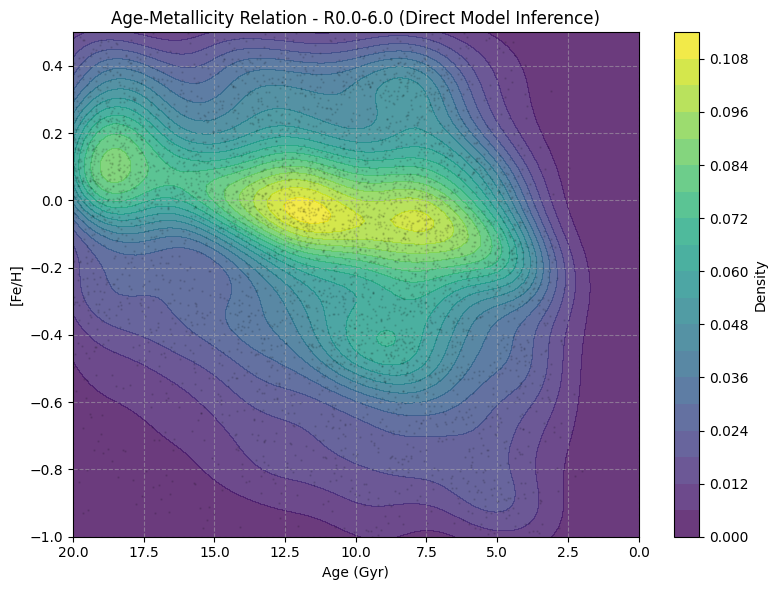

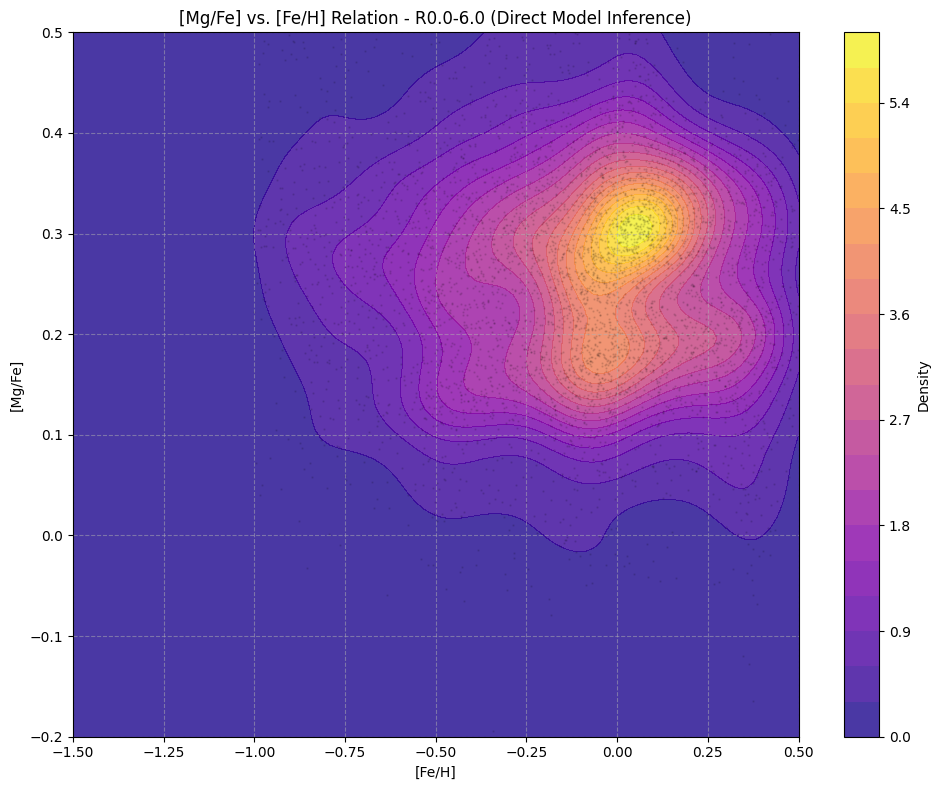

In [8]:
# Test model sampling
if flow_models:
    bin_name = list(flow_models.keys())[0]  # Get first available bin
    model = flow_models[bin_name]
    scaler = scalers[bin_name]

    print(f"Testing sampling from {bin_name} model...")
    ages, fehs, mgfes, success = sample_flow_model(
        model, scaler, n_samples=5000,
        age_range=(0, 20), feh_range=(-1., 0.5)
    )

    if success:
        title_suffix = "(Direct Model Inference)"
    else:
        title_suffix = "(Synthetic Data)"

    fig, ax = plot_age_metallicity_kde(
        ages, fehs, bin_name=bin_name,
        age_range=(0, 20), feh_range=(-1., 0.5),
        title_suffix=title_suffix
    )
    plt.show()

    fig, ax = plot_mgfe_feh_kde(
        fehs, mgfes, bin_name=bin_name,
        title_suffix=title_suffix
    )
    plt.show()
else:
    print("No models available for testing.")